### Multivariate state estimation technique

Моделирование системы в **$MSET$ использует данные, представляющие нормальные рабочие состояния системы** (данные без аномалий), и изучает взаимосвязи, существующие между переменными, используемыми для определения состояния. Иными словами, есть набор переменных которые описывают нормальное рабочее состояние системы. С помощью метода изучаются связи между такими переменными. Тогда при анализе данных с аномалиями эти связи могут быть нарушены, что и служит индикатором для обнаружения аномалий.

Собранные данные организуются в виде матрицы, где каждый вектор-столбец представляет измерения в момент времени $t_j$. Количество столбцов этой матрицы равно количеству наблюдений во времени, а количество строк равно количеству измеряемых показателей. Например, можно измерять давление, температуру и напряжение - это строки в матрице, тогда каждый столбец это состояние в конкретный момент времени.

<img src="mset_data.png" alt="Drawing" style="width: 400px; height: 200px"/>

В общем случае $x_{ji}$ - значение параметра $j$ в момент времени $i$. Тогда состояние в момент времени $X(t_i) = [x_{1i}, x_{2i} \ldots x_{ni}]^T$.

В процессе $MSET$ есть три ключевые процедуры (выполняются последовательно):
1. Выбор обучающих данных $T$ из матрицы $X_i(t_i)$.
2. Выбор данных для создания матрицы памяти $D$
3. Обучение и принятие решения

**Обучающие данные**. Определяются просто как $T \subset X_i(t_i)$, т.е. берется подмножество столбцов (состояний), при этом требуется чтобы данные не содержали аномалий и не нарушали целостность системы (это значит, что нельзя из момента времени выбросить один или несколько показателей). Размер подмножества $|T|$ определяется пользователем, скорее всего как гиперпараметр.

**Матрица памяти**. Определяется как подмножество $D \subset T$, при этом есть конструктивный алгоритм построения:
1. Состояния, которые содержат максимальные и минимальные значения характеристик системы, должны быть выбраны.
2. Из оставшихся данных выбираются состояния согласно алгоритму:
    * Упорядочиваем вектора на основе евклидовых норм
    * Добиваем до заданного вручную количества $|D|$ через равные интервалы
    * Оставшиеся состояния будут образовывать матрицу $L$

*Мое мнение, чем больше матрица памяти тем лучше*

Таким образом $T = D \cup L$. Весь процесс можно представить в виде блок-схемы:

<img src="mset_process.png" alt="Drawing" style="width: 700px; height: 200px"/>

Матрица $D$ характеризует нормальное рабочее состояние системы и играет ключевую роль. Именно под нее в процессе обучения выбираются веса по которым можно оценивать новые наблюдения.

**Обуение**. Итак, допустим мы построили матрицу памяти. Теперь нужно обучиться (к слову $MSET$ это *supervised* метод). Идея заключается просто во взвешивании, т.е. по сути решается задача регресии. Пусть $X_{obs}$ наблюдаемые новые состояния системы. Тогда $X_{est} = DW$, где $W$ - стобец весов. Ошибка обучения $\epsilon = X_{obs} - X_{est} = X_{obs} - DW$. Ясно, что $\epsilon \perp d_i$, где $d_i$ вектор-столбец из $D$. Почему это так? Рассмотрим задачу регресии как задачу проецирования из линейной алгберы.

Пусть у нас есть объекты $x \in R^n$, в качестве $n$ возьмем $3$, потому что это нагляднее, но на самом деле верно и для большего $n$. И пусть мы по двум измерениям (осям $X$ и $Y$) хотим предсказывать значение по оси $Z$. Окей, берем векторы в пространстве и просто проецируем на плоскость $XY$. В плоскости $XY$ есть базис, спроецированные векторы пространства можно единственным образом разложить по этому базису. Коэффициенты разложения по базису назовем весами. Тогда если вычесть из вектора в пространстве $XYZ$ его проекцию в $XY$, получим направляющий вектор плоскости $XY$. А значит любой вектор из плоскости, в том числе и базисный, перпендикулярен направляющему вектору. В этом примере базисные-вектора на плоскости это вектора матрицы $D$, направляющий вектор это $\epsilon$, а $X_{obs}$ это вектора в пространстве.

Поскольку $\epsilon \perp d_i$, то скалярное произведение $<\epsilon, d_i> = 0$, где $d_i$ вектор-столбец из матрицы $D$. Давайте рассмотрим скалярные произведение со всеми векторами из матрицы $D$, т.е. $<\epsilon, d_1> = <\epsilon, d_2> = \ldots = <\epsilon, d_{|D|}> = 0$. Это также можно записать в виде матричного умножения $D^T \epsilon = 0$. Подставим эпсилон и раскроем скобки, получается 
$$D^T(X_{obs} - DW) = 0$$
$$D^T X_{obs} = D^T D W$$
$$[D^TD]^{-1} [D^T X_{obs}] = W$$ при этом матрица $D^TD$ должна быть обратима

Иначе во второй строке обозначаем $D^TX_{obs} = B$, $D^TD = A$, $W = x$ и решаем СЛУ вида $Ax = B$

Таким образом находим вектор весов, тогда $X_{est} = D [D^TD]^{-1} [ D^T X_{obs}]$

Аналогично оцениваем остатки матрицы $L$, а затем легко вычисляем остатки $R_X = X_{est} - X_{obs}$ и $R_L = L_{est} - L_{obs}$

**Принятие решения**. Наша цель обнаружить аномалии, поэтому нужно оценить остатки на соответствие белому шуму. Это можно сделать, например, с помощью метода статистического принятия решений $SPRT$ [cool theory with example](https://www.weibull.com/hotwire/issue162/hottopics162.htm)

### Обнаружение аномалий на синтетических данных

Сразу же добавим столбец нормы для дальнейшего построение матрицы $D$

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/anomaly-free/anomaly-free.csv", sep=";", index_col="datetime")

norms = []
for i in range(df.shape[0]):
    state = df.loc[df.index[i]]
    norm = np.linalg.norm(state)
    norms.append(norm)
    
df["Norm"] = norms
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,Norm
datetime,,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664,284.673953
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338,275.490520
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338,271.360938
2020-02-08 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664,289.413794
2020-02-08 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000,284.686623


Согласно алгоритму добавляем максимальные и минимальные показатели по каждому измерению

In [3]:
D = pd.DataFrame()

for column in df.columns:
    max_vals = df[df[column] == df[column].max()]
    D = pd.concat([D, max_vals])

In [4]:
df_copy = df.copy()
df_copy.sort_values("Norm")
df_copy.drop(D.index, inplace=True)

Добиваем матрицу $D$ оставшимися значениями через заданные интервал

In [5]:
k = 0.8; shift = 3
dsize = int(k * df_copy.shape[0])
while D.shape[0] <= dsize:
    states = pd.DataFrame()
    for i in range(0, df_copy.shape[0], shift):
        state = df_copy[i:i+1]
        states = pd.concat([states, state])
    
    D = pd.concat([D, states])
    df_copy.drop(states.index, inplace=True)
    
D = D[:dsize]

In [6]:
L = df_copy

In [7]:
D.drop(["Norm"], inplace=True, axis=1)

In [8]:
L.drop(["Norm"], inplace=True, axis=1)

Загружаем датасет с аномалиями, обучаемся и оцениваем остатки

In [9]:
df_an = pd.read_csv("data/valve1/0.csv", sep=";", index_col="datetime")
df_an.drop(["anomaly", "changepoint"], inplace=True, axis=1)

In [10]:
W = np.linalg.inv(D @ D.T) @ (np.array(D) @ np.array(df_an.T))

In [11]:
X_est = np.array(D.T) @ W

In [12]:
rest = X_est - np.array(df_an.T)

In [23]:
rest.shape

(8, 1147)

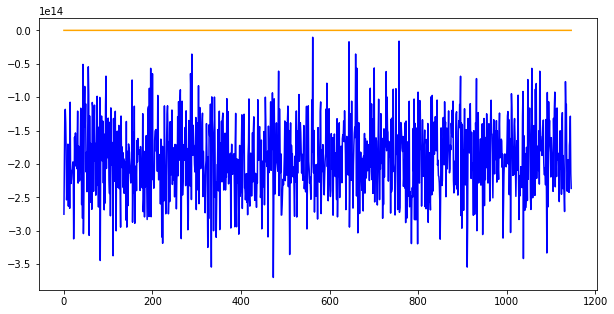

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X_est[0], color='blue')
ax.plot(np.array(df_an.T)[0], color='orange')

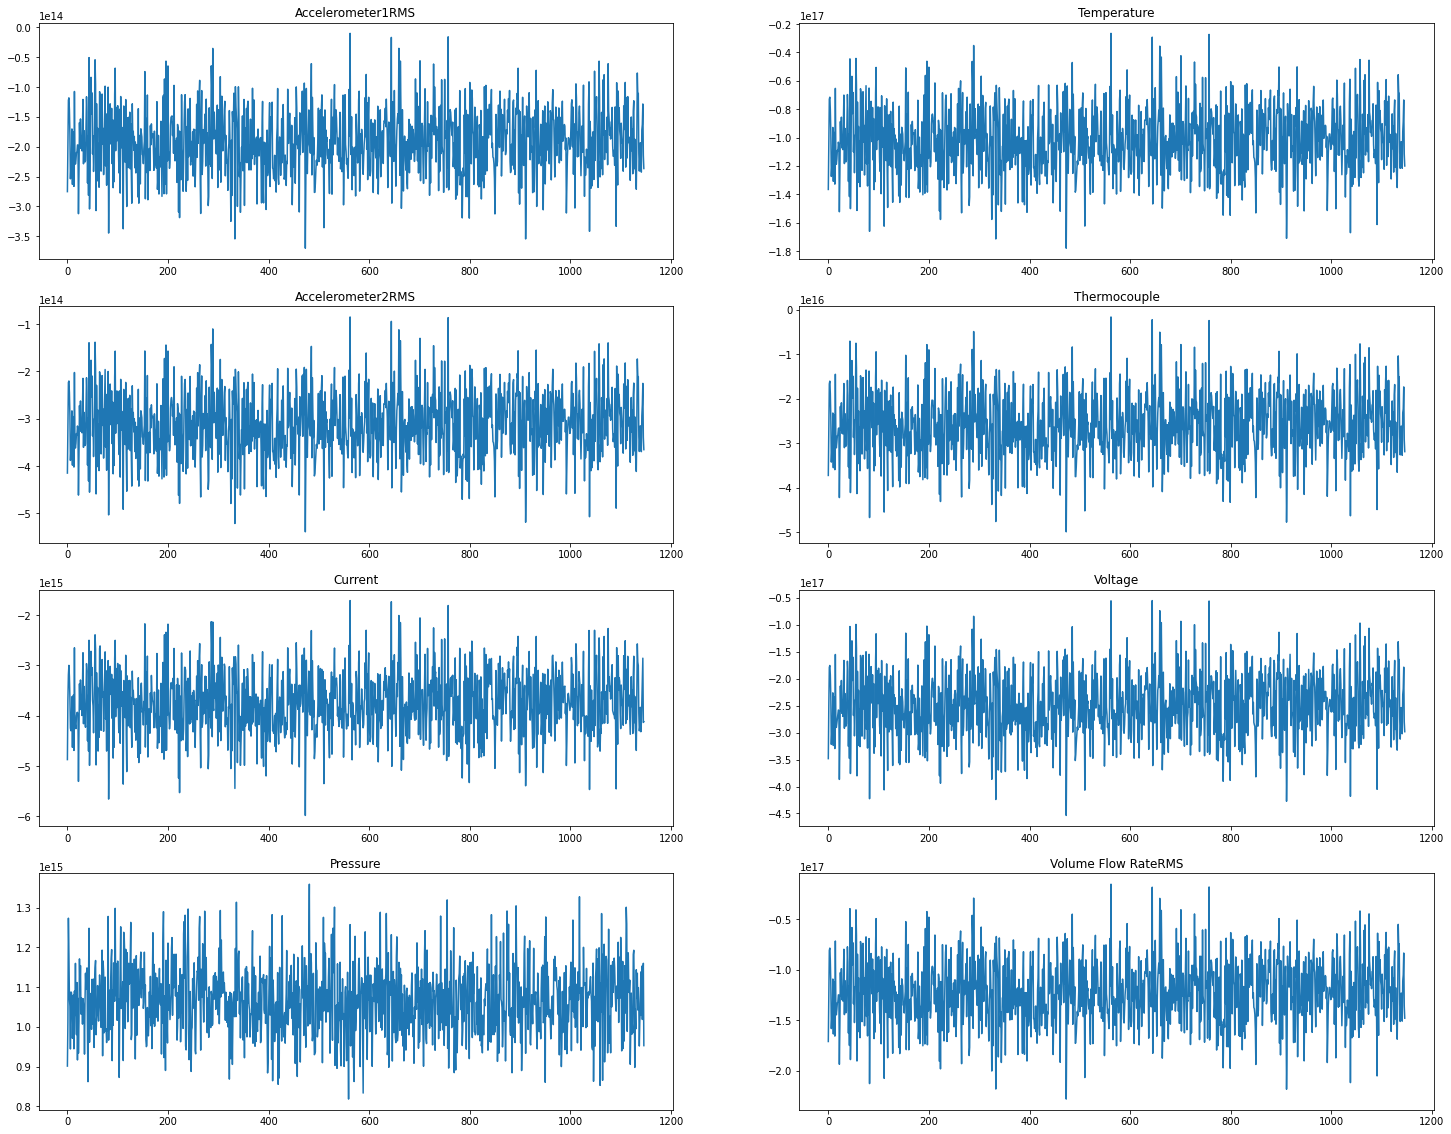

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(25, 20))

for i in range(rest.shape[0]):
    j = 1 if i >= 4 else 0
    axes[i%4, j].plot(rest[i])
    axes[i%4, j].set_title(df.columns[i])
plt.show()

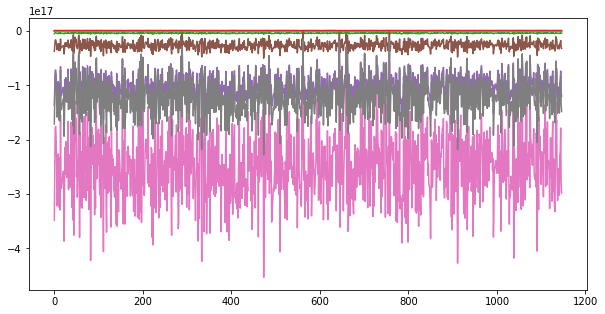

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots((1, rest.shape[0]), figsize=(10, 5))
for i in range(rest.shape[0]):   
    ax.plot(rest[i])
plt.show()

Метрики качества модели $FAR$ и $MAR$

In [14]:
def mar(test, pred):
    fn = ((pred == 0) & (test > 0)).sum()
    tp = ((pred > 0) & (test > 0)).sum()
    return fn / (tp + fn)

def far(test, pred):
    fp = ((pred > 0) & (test == 0)).sum()
    tn = ((pred == 0) & (test > 0)).sum()
    return fp / (fp + tn)